<a href="https://colab.research.google.com/github/rachid-boudour/RecMORL-Selection/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.preprocessing import LabelEncoder
import time
import pickle
import numpy as np
from collections import defaultdict
import torch.nn.functional as F

# =====================================
# 1. Enhanced Data Preparation for GNN
# =====================================

dataset = pd.read_csv("interactions200K_collab_V2.csv")

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
dataset["user_id"] = user_encoder.fit_transform(dataset["user_id"])
dataset["service_id"] = item_encoder.fit_transform(dataset["service_id"])

dataset = dataset.sort_values(by=["user_id", "timestamp"])

user_service_edges  = []
service_service_edges = []
session_sequences   = []

user_service_map = defaultdict(list)
for _, row in dataset.iterrows():
    user_service_map[row["user_id"]].append(row["service_id"])

for user_id, services in user_service_map.items():
    for service_id in services:
        user_service_edges.append([user_id, service_id])

for user_id, group in dataset.groupby("user_id"):
    services = group["service_id"].tolist()
    for i in range(len(services)-1):
        service_service_edges.append([services[i], services[i+1]])

sessions = []
for user_id, group in dataset.groupby("user_id"):
    group = group.reset_index(drop=True)
    if len(group) >= 3:
        for i in range(len(group) - 2):
            window = group.iloc[i:i+3]
            sessions.append(window)

split_idx = int(0.75 * len(sessions))
train_sessions = sessions[:split_idx]
test_sessions  = sessions[split_idx:]

# =====================================
# 2. PyTorch Geometric Dataset
# =====================================

class GNNSessionDataset(Dataset):
    def __init__(self, sessions, user_service_edges, service_service_edges):
        self.sessions = sessions
        self.num_users   = len(user_encoder.classes_)
        self.num_services= len(item_encoder.classes_)

        self.edge_index = torch.tensor(user_service_edges, dtype=torch.long).t()
        self.edge_index = torch.cat([
            self.edge_index,
            torch.tensor(service_service_edges, dtype=torch.long).t()+self.num_users
        ], dim=1)

        self.node_features = torch.randn(self.num_users + self.num_services, 64)

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        session = self.sessions[idx]
        user_id  = session.iloc[0]["user_id"]
        services = session["service_id"].tolist()
        X = np.array([user_id, services[0], services[1]])
        y = session.iloc[2]["service_id"]

        node_mask = torch.zeros(self.num_users + self.num_services, dtype=torch.bool)
        node_mask[user_id] = True
        node_mask[self.num_users + services[0]] = True
        node_mask[self.num_users + services[1]] = True

        return {
            'node_features': self.node_features,
            'edge_index':      self.edge_index,
            'node_mask':       node_mask,
            'target_service':  torch.tensor(y, dtype=torch.long),
            'user_id':         torch.tensor(user_id, dtype=torch.long),
            'service_history': torch.tensor([services[0], services[1]], dtype=torch.long)
        }

def collate_fn(batch):
    return {
        'node_features':     batch[0]['node_features'],
        'edge_index':        batch[0]['edge_index'],
        'node_mask':         torch.stack([b['node_mask']         for b in batch]),
        'target_service':    torch.stack([b['target_service']    for b in batch]),
        'user_id':           torch.stack([b['user_id']           for b in batch]),
        'service_history':   torch.stack([b['service_history']   for b in batch])
    }

train_dataset = GNNSessionDataset(train_sessions, user_service_edges, service_service_edges)
test_dataset  = GNNSessionDataset(test_sessions,  user_service_edges, service_service_edges)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_fn)

# =====================================
# 3. GNN Model Architecture
# =====================================

class IoTServiceGNN(nn.Module):
    def __init__(self, num_users, num_services, embedding_dim=64, hidden_dim=128):
        super(IoTServiceGNN, self).__init__()
        self.num_users    = num_users
        self.num_services = num_services

        self.user_embedding    = nn.Embedding(num_users, embedding_dim)
        self.service_embedding = nn.Embedding(num_services, embedding_dim)

        self.conv1 = GATConv(embedding_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim,    hidden_dim)

        self.seq_attention = nn.MultiheadAttention(hidden_dim, num_heads=4)
        self.fc            = nn.Linear(hidden_dim * 2, num_services)

    def forward(self, node_features, edge_index, node_mask, user_id, service_history):
        user_emb    = self.user_embedding(user_id)
        service_emb = self.service_embedding(service_history)

        x = node_features.clone()
        x[user_id] = user_emb
        for i in range(service_history.size(1)):
            x[self.num_users + service_history[:, i]] = service_emb[:, i, :]

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)

        batch_size = user_id.size(0)
        user_repr    = x[user_id]
        service_nodes = self.num_users + service_history
        service_repr  = x[service_nodes]

        service_repr = service_repr.transpose(0,1)  # [seq_len, batch_size, hidden_dim]
        attn_output, _ = self.seq_attention(service_repr, service_repr, service_repr)
        attn_output = attn_output.mean(dim=0)

        combined = torch.cat([user_repr, attn_output], dim=1)
        out      = self.fc(combined)
        return out

# =====================================
# 4. Training Setup
# =====================================

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = IoTServiceGNN(num_users=len(user_encoder.classes_),
                         num_services=len(item_encoder.classes_)).to(device)
loss_fn  = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# =====================================
# 5. Evaluation metrics
# =====================================

def evaluate_topk(model, loader, k=5):
    model.eval()
    HRs, MRRs, Recalls, nDCGs = [], [], [], []
    with torch.no_grad():
        for batch in loader:
            node_features    = batch['node_features'].to(device)
            edge_index       = batch['edge_index'].to(device)
            user_id          = batch['user_id'].to(device)
            service_history  = batch['service_history'].to(device)
            targets          = batch['target_service'].to(device)

            out    = model(node_features, edge_index, None, user_id, service_history)
            topk_vals, topk_idx = torch.topk(out, k, dim=1)

            batch_size = user_id.size(0)
            for i in range(batch_size):
                gt    = targets[i].item()
                preds = topk_idx[i].cpu().tolist()

                # HR@k
                HRs.append(1 if gt in preds else 0)

                # MRR@k
                if gt in preds:
                    rank = preds.index(gt) + 1
                    MRRs.append(1.0 / rank)
                else:
                    MRRs.append(0.0)

                # Recall@k  (assuming one ground-truth per session)
                Recalls.append(1 if gt in preds else 0)

                # nDCG@k
                if gt in preds:
                    rank = preds.index(gt) + 1
                    dcg  = 1.0 / np.log2(rank + 1)
                    idcg = 1.0 / np.log2(1 + 1)
                    nDCGs.append(dcg / idcg)
                else:
                    nDCGs.append(0.0)

    return {
        f'HR@{k}'   : np.mean(HRs),
        f'MRR@{k}'  : np.mean(MRRs),
        f'Recall@{k}' : np.mean(Recalls),
        f'nDCG@{k}' : np.mean(nDCGs)
    }

# =====================================
# 6. Training Loop
# =====================================

EPOCHS     = 5
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        node_features    = batch['node_features'].to(device)
        edge_index       = batch['edge_index'].to(device)
        user_id          = batch['user_id'].to(device)
        service_history  = batch['service_history'].to(device)
        targets          = batch['target_service'].to(device)

        optimizer.zero_grad()
        out   = model(node_features, edge_index, None, user_id, service_history)
        loss  = loss_fn(out, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    metrics = evaluate_topk(model, test_loader, k=5)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | HR@5: {metrics['HR@5']:.4f} | "
          f"MRR@5: {metrics['MRR@5']:.4f} | Recall@5: {metrics['Recall@5']:.4f} | "
          f"nDCG@5: {metrics['nDCG@5']:.4f}")

print(f"Training done in {time.time()-start_time:.2f} sec")

# =====================================
# 7. Save Model and Encoders
# =====================================

torch.save(model.state_dict(), "gnn_model.pt")
with open("item_encoder.pkl", "wb") as f:
    pickle.dump(item_encoder, f)
with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

# =====================================
# 8. Enhanced Recommendation Function
# =====================================

def gnn_recommend_next_item(user_id_raw, session_items_raw, model, user_encoder, item_encoder):
    model.eval()
    try:
        encoded_user  = user_encoder.transform([user_id_raw])[0]
        encoded_items = item_encoder.transform(session_items_raw)
    except ValueError as e:
        print("⚠️ One or more items are unknown to the encoder:", e)
        return None

    user_id_tensor     = torch.tensor([encoded_user], dtype=torch.long).to(device)
    service_history    = torch.tensor([encoded_items], dtype=torch.long).to(device)

    with torch.no_grad():
        node_features = torch.randn(model.num_users + model.num_services, 64).to(device)
        edge_index    = train_dataset.edge_index.to(device)
        out           = model(node_features, edge_index, None, user_id_tensor, service_history)
        pred_id       = torch.argmax(out, dim=1).item()

    return item_encoder.inverse_transform([pred_id])[0]

example_user    = "user_123"
example_session = ["service_1", "service_3", "service_1"]
predicted       = gnn_recommend_next_item(example_user, example_session, model, user_encoder, item_encoder)
print("🔮 Next item predicted:", predicted)


Epoch 1 | Loss: 2.2341 | Test acc: 26.92%
Epoch 2 | Loss: 2.2062 | Test acc: 26.92%
Epoch 3 | Loss: 2.1990 | Test acc: 26.92%
Epoch 4 | Loss: 2.1931 | Test acc: 26.92%
Epoch 5 | Loss: 2.1872 | Test acc: 26.92%
Training done in 1346.85 sec
🔮 Next item predicted: service_1


/tmp/ipython-input-3035555490.py:289: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  service_history = torch.tensor([encoded_items], dtype=torch.long).to(device)


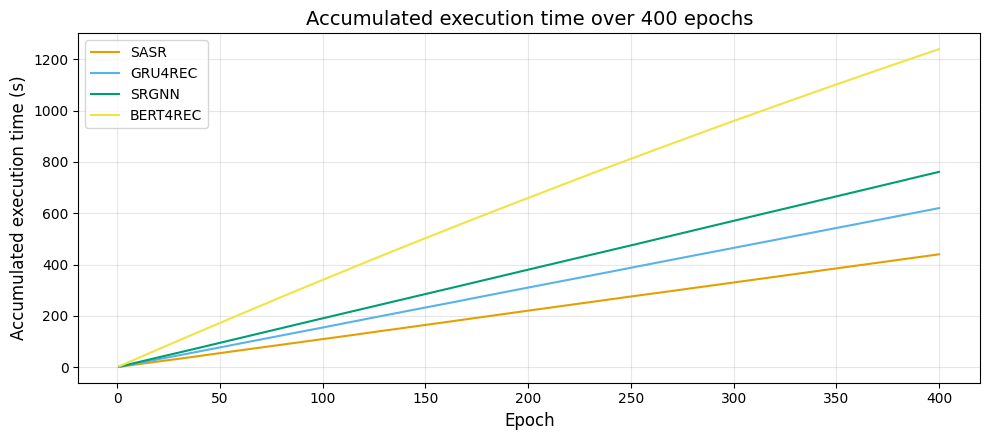

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate dummy data (replace with your actual arrays)
epochs = np.arange(1, 401)
sasr = np.random.normal(1.1, 0.05, len(epochs))
gru4rec = np.random.normal(1.55, 0.05, len(epochs))
srgnn = np.random.normal(1.9, 0.05, len(epochs))
bert4rec = 3.5 - 0.002 * epochs + np.random.normal(0, 0.05, len(epochs))

# Compute accumulated execution time
sasr_cum = np.cumsum(sasr)
gru4rec_cum = np.cumsum(gru4rec)
srgnn_cum = np.cumsum(srgnn)
bert4rec_cum = np.cumsum(bert4rec)

# Create the plot
plt.figure(figsize=(10, 4.5))
plt.plot(epochs, sasr_cum, label='SASR', color='#E69F00', linewidth=1.5)
plt.plot(epochs, gru4rec_cum, label='GRU4REC', color='#56B4E9', linewidth=1.5)
plt.plot(epochs, srgnn_cum, label='SRGNN', color='#009E73', linewidth=1.5)
plt.plot(epochs, bert4rec_cum, label='BERT4REC', color='#F0E442', linewidth=1.5)

plt.title('Accumulated execution time over 400 epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accumulated execution time (s)', fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Save as vector graphic for LaTeX
plt.tight_layout()
plt.savefig('accumulated_execution_time.pdf', format='pdf')
plt.savefig('accumulated_execution_time.eps', format='eps')
plt.show()

#files.download('execution_time.pdf')